In [102]:
import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as smf
import urllib.request
import zipfile

In [103]:
def get_fama_french(period="M"):
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    
    # Download the file and save it  
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Extact the file data
    zip_file.extractall()
    zip_file.close()
    
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)
   
    # Skip null rows
    ff_row = ff_factors.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
    
    # Format dates to end of month
    ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
    
    # Resample the data to correct frequency
    ff_factors = ff_factors.resample(period).last()
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

In [104]:
def get_momentum(period="M"):
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
    
    # Download the file and save it  
    urllib.request.urlretrieve(url,'momentum.zip')
    zip_file = zipfile.ZipFile('momentum.zip', 'r')
    
    # Extact the file data
    zip_file.extractall()
    zip_file.close()
    
    momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, index_col = 0)
   
    # Skip null rows
    row = momentum_factor.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    momentum_factor = pd.read_csv('F-F_Momentum_Factor.csv', skiprows = 13, nrows = row, index_col = 0)
    
    # Format the date index
    momentum_factor.index = pd.to_datetime(momentum_factor.index, format= '%Y%m')
    
    # Format dates to end of month
    momentum_factor.index = momentum_factor.index + pd.offsets.MonthEnd()
    
     # Resample the data to correct frequency
    momentum_factor = momentum_factor.resample(period).last()
    
    # Convert from percent to decimal
    momentum_factor = momentum_factor.apply(lambda x: x/ 100)
    return momentum_factor

In [105]:
def get_return_data(price_data, period = "M"):
    
    # Resample the data to monthly price
    price = price_data.resample(period).last()
    
    # Calculate the percent change
    ret_data = price.pct_change()[1:]
    
    # Convert from series to dataframe
    ret_data = pd.DataFrame(ret_data)
    
    return ret_data

In [106]:
# def get_mu_Q(exRets, factor_data, regress_type="Linear"):

#     # Calculate the factor expected excess return from historical data using the geometric mean
#     gmean = stats.gmean(factor_data + 1,axis=0) - 1
#     n_factors = len(gmean)
 
#     # Calculate the factor covariance matrix
#     F = factor_data.cov()
    
#     # Set up X and Y to determine alpha and beta
#     factor_data['Ones'] = [1 for i in range(len(factor_data))]
#     X = factor_data
#     Y = exRets
#     X = X.to_numpy()
#     Y = Y.to_numpy()
    
#    # Determine alpha and beta
#     if regress_type == "Linear":
#         model = LinearRegression().fit(X,Y)
#     elif regress_type == "Lasso":
#         model = Lasso().fit(X,Y)
#     else:
#         model = Ridge().fit(X,Y)
#     alpha = model.intercept_
#     beta = model.coef_[:,0:n_factors]

#     # Calculate the residuals 
#     alpha = np.reshape(alpha,(alpha.size,1))
#     epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))
    
#     # Calculate the residual variance with "N - p - 1" degrees of freedom
#     p = 3
#     sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)
    
#     #  Calculate the asset expected excess returns
#     mu = model.predict([np.append(gmean,1)])[0]
    
#     # Calculate the diagonal matrix of residuals and the asset covariance matrix
#     D = np.diag(sigmaEp)
    
#     # Calculate the covariance matrix
#     Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D

    
#     return mu, Q

In [107]:
# get_mu_Q(exRets, ff_data)

In [108]:
def get_mu_Q_multiperiod(exRets, factor_data, lookahead, lookback, regress_type="Linear"):
    """
    exRets: excess return data for stocks
    factor_data: factor return data
    lookahead: number of periods in the future to estimate
    lookback: number of periods in the past to use for estimations
    regress_type: can be 'Linear', 'Lasso', or 'Ridge'
    """
    
    # For keeping track of mu's and Q's from each period
    mu_arr = []
    Q_arr = []
            
    n_factors = len(factor_data.columns)
    factor_data = factor_data.tail(lookback)
    exRets = exRets.tail(lookback)

    for i in range(0, lookahead):

        # Calculate the factor covariance matrix
        F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()
        
        # Calculate the factor expected excess return from historical data using the geometric mean
        factor_data['Ones'] = [1 for i in range(len(factor_data))]
        gmean = stats.gmean(factor_data + 1,axis=0) - 1

        # Set up X and Y to determine alpha and beta
        X = factor_data
        Y = exRets
        X = X.to_numpy()
        Y = Y.to_numpy()

       # Determine alpha and beta
        if regress_type=="Linear":
            model = LinearRegression().fit(X,Y)
        elif regress_type=="Lasso":
            model = Lasso().fit(X,Y)
        elif regress_type=="Ridge":
            model = Ridge().fit(X,Y)
        else:
            print("Error: This type of regression has not been implemented.")
        alpha = model.intercept_
        beta = model.coef_[:,0:n_factors]

        # Calculate the residuals 
        alpha = np.reshape(alpha,(alpha.size,1))
        epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

        # Calculate the residual variance with "N - p - 1" degrees of freedom
        p = 3
        sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)

        #  Calculate the asset expected excess returns
        mu = model.predict([gmean])[0]

        # Calculate the diagonal matrix of residuals and the asset covariance matrix
        D = np.diag(sigmaEp)

        # Calculate the covariance matrix
        Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D
        
        # Add mu and Q to array
        mu_arr.append(mu)
        Q_arr.append(Q)
        
        # Update for next time step
        factor_data = factor_data[1:]
        factor_append = pd.Series(gmean, index = factor_data.columns)
        factor_data.append(factor_append, ignore_index=True)
        
        exRets = exRets[1:]
        mu_append = pd.Series(mu, index=exRets.columns)
        exRets.append(mu_append, ignore_index=True)   
        
    return mu_arr, Q_arr

In [109]:
# def get_mu_Q_PCA(price_data, K):
#     # Calculate excess returns 
#     exRets = get_return_data(price_data)
    
#     meanRets = 
    
#     return mu, Q

In [110]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std

In [111]:
def portfolio_returns(weights, mean_returns, cov_matrix):
    return np.sum(mean_returns*weights ) *252

In [112]:
def min_variance(mean_returns, cov_matrix, target_return=0.1):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'eq', 'fun': lambda x: target_return - portfolio_returns(x, mean_returns, cov_matrix)})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

In [113]:
# Get price data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
price_data.index = pd.to_datetime(price_data.index)

In [114]:
'''Fama-French'''

ff_data = get_fama_french()
ff_data = ff_data.iloc[:,0:3] 

# Make dates consistent between price and factor data
exRets = get_return_data(price_data)
factor_last = ff_data.index[ff_data.shape[0] - 1].date()
exRets = exRets.loc[:factor_last]
price_first = exRets.index[0].date()
ff_data = ff_data.loc[price_first:]

mu, Q = get_mu_Q_multiperiod(exRets, ff_data,3,24, "Lasso")
print(mu)
print(Q)
#min_variance(mu,Q)

c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  app.launch_new_instance()
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[array([-0.03697805,  0.03595776,  0.00302023,  0.00372824,  0.01828471,
        0.01450707,  0.02777152,  0.01452479, -0.00067025, -0.00147543,
        0.02241323, -0.047438  ,  0.01044382,  0.00772261,  0.01478009,
       -0.00835507, -0.01822048, -0.00811522,  0.006968  ,  0.01676324,
        0.01910493,  0.00387849,  0.00821292, -0.01573706, -0.00013147,
       -0.00070057,  0.0233397 ,  0.05537651,  0.0131501 ,  0.011132  ,
       -0.02298518,  0.00909742,  0.02271483,  0.02382754,  0.0277288 ,
        0.00310149,  0.01491341,  0.00376666,  0.02746187,  0.02659415,
        0.00986485,  0.01184095,  0.00345212, -0.00511098,  0.02015681,
        0.00994245,  0.02238753,  0.00075454, -0.01205746,  0.02054828,
        0.01789136, -0.00329157,  0.00462296, -0.02223734,  0.02317666,
       -0.00185438, -0.01190008, -0.00312323, -0.01315519,  0.01076672,
        0.02913553,  0.0012145 ,  0.00223081,  0.00346247, -0.01352472,
        0.00988338, -0.00193751,  0.00258813, -0.00021657, -0.0

In [115]:
# # Run optimization for CAPM
# CAPM_data = ff_data.iloc[:,0:1] #first column of FF data is just market rf
# mu, Q = get_mu_Q(price_data, CAPM_data)
# min_variance(mu,Q)

In [116]:
# # Run optimization for Carhart (FF + momentum)
# momentum_factor = get_momentum()
# carhart_data = pd.concat([ff_data, momentum_factor], axis=1).dropna()
# mu, Q = get_mu_Q(price_data, carhart_data)
# min_variance(mu,Q)

In [155]:
def backtest(rebal_freq, start_date, end_date, exRets, lookback=24, lookahead=3, factor_model = "FF", regress_type = "Lasso"):
    """start_date and end_date format should be "%d%m%Y", e.g. "24052010" """
    
    start_date = datetime.datetime.strptime(start_date, "%d%m%Y").date()
    end_date = datetime.datetime.strptime(end_date, "%d%m%Y").date()  
    
    stock_returns = exRets.loc[start_date:] 
    portfolio_returns = []
    
    n_periods = int((12*(end_date.year - start_date.year) + (end_date.month - start_date.month))/rebal_freq)
    
    if factor_model == "FF":
        factor_data = get_fama_french()
        factor_data = factor_data.iloc[:,0:3]    
    
    #elif other factor models blahblah
    
#     exRets = exRets.loc[start_date-relativedelta(months=lookback):end_date]
#     factor_data = factor_data.loc[start_date-relativedelta(months=lookback):end_date]
            
    for i in range(n_periods):
        exRets_i = exRets.loc[start_date + relativedelta(months= i*rebal_freq - lookback) : start_date + relativedelta(months= i*rebal_freq)]
        factor_data_i = factor_data.loc[start_date + relativedelta(months= i*rebal_freq - lookback) : start_date + relativedelta(months= i*rebal_freq)]

        mu, Q = get_mu_Q_multiperiod(exRets_i, factor_data_i, lookahead, lookback, regress_type)

            
        #INSERT PREDICTED WEIGHTS, SHOULD BE 1D ARRAY (1 x number of stocks)
        #weights = INSERTMODELHERE(mu,Q)
        #DELETE LINE BELOW - JUST A PLACEHOLDER
        weights = [1/len(exRets.columns) for i in range(len(exRets.columns))]

        period_return = sum(weights*stock_returns.iloc[(i+1)*rebal_freq])
        portfolio_returns.append(period_return)
    return portfolio_returns

In [156]:
import matplotlib.pyplot as plt

portfolio_returns = backtest(1, '31102014', '31102019', exRets)


c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  app.launch_new_instance()
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A v

c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\dorot\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

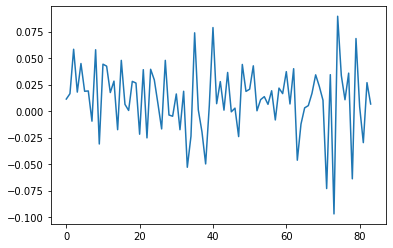

In [150]:
start_date = "31102012"
end_date = "31102019"
start_date = datetime.datetime.strptime(start_date, "%d%m%Y").date()
end_date = datetime.datetime.strptime(end_date, "%d%m%Y").date() 
rebal_freq = 1
n_periods = int((12*(end_date.year - start_date.year) + (end_date.month - start_date.month))/rebal_freq)
plt.plot([i for i in range(n_periods)], portfolio_returns)